# Explore `meta-kaggle` Dataset

## --- Effort Estimation

Pre-requisites: 

1. Install Python package `kaggle`
2. [Create token](https://www.kaggle.com/docs/api) and 
3. Put the `kaggle.json` file to the `.kaggle` folder of your home directory
4. Download dataset `meta-kaggle` if haven't yet, by excuting: 
   ```python
   from metakaggle import api
   api.download_rawdata(rawdata_path)
   ```

In [3]:
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.axis import Axis
from matplotlib.figure import Figure

from typing import Iterable
from datetime import datetime

import metakaggle as mk

In [4]:
rawdata_path = os.path.abspath('./rawdata')

### 1. Mapping Datasets

Create a dataset of submissions, containing the following fields:
- Id 
- TeamId 
- CompetitionId 
- SubmissionDate
- PublicScore
- PrivateScore

In [5]:
# Submissions
# - TeamId
# - SubmissionDate
tbl_submissions = mk.table_filter( \
	'Submissions', rawdata_path,
	fields = ['Id', 'TeamId', 'SubmissionDate', 'IsAfterDeadline',
		'PublicScoreLeaderboardDisplay', 'PrivateScoreFullPrecision'],
	fields_index = ['Id'],
	fields_datetime = ['SubmissionDate'],
)
# drop all submissions after deadlines
tbl_submissions = tbl_submissions[~tbl_submissions['IsAfterDeadline']]
tbl_submissions.drop('IsAfterDeadline', axis=1, inplace=True)
# rename long name
tbl_submissions.rename(columns={
	'PublicScoreLeaderboardDisplay': 'PublicScore',
	'PrivateScoreFullPrecision': 'PrivateScore'
}, inplace=True)

In [6]:
# Mapping: Teams
# - CompetitionId
map_teams_competitions = mk.table_filter( \
	'Teams', rawdata_path,
	fields = ['Id', 'CompetitionId'],
	fields_index = ['Id'],
)

In [7]:
# Merge `Submissions` and `TeamsCompetition`
tbl_submissions = pd.merge(tbl_submissions, map_teams_competitions,
	how = 'left', left_on = 'TeamId', right_on = 'Id', sort = False,
	suffixes=('', '_Team'))
tbl_submissions.drop(columns='Id_Team', inplace=True)
tbl_submissions.dtypes

Id                         int64
TeamId                     int64
SubmissionDate    datetime64[ns]
PublicScore              float64
PrivateScore             float64
CompetitionId              int64
dtype: object

### 2. Splitting Submissions Data by Contest Types

In [8]:
# # explore `Competitions` dataset
# import pprint
# pprint.pprint(list(mk.table_header('Competitions', rawdata_path, n=1).keys()))

In [9]:
# Table of Contests
tbl_contests = mk.table_filter( \
	'Competitions', rawdata_path,
	fields=['Id',
		'EnabledDate', 'DeadlineDate', 'ProhibitNewEntrantsDeadlineDate',
		'TeamMergerDeadlineDate', 'TeamModelDeadlineDate', 'TeamModelDeadlineDate',
		'ModelSubmissionDeadlineDate',
		'HasLeaderboard', 'LeaderboardPercentage', 'MaxDailySubmissions',
		'RewardType', 'RewardQuantity', 'NumPrizes',
		'FinalLeaderboardHasBeenVerified'
	],
	fields_datetime=[
		'EnabledDate', 'DeadlineDate', 'ProhibitNewEntrantsDeadlineDate',
		'TeamMergerDeadlineDate', 'TeamModelDeadlineDate', 'TeamModelDeadlineDate',
		'ModelSubmissionDeadlineDate'
	],
	fields_index=['Id'],
)
len(tbl_contests)

9442

In [10]:
print('How many contests are there having records of submissions from players?')
lst_contests_with_submissions = tbl_submissions['CompetitionId'].unique()
print(len(lst_contests_with_submissions))

# Filter
tbl_contests = tbl_contests[tbl_contests['Id'].isin(lst_contests_with_submissions)]

How many contests are there having records of submissions from players?
5693


In [11]:
print('Is there never-ending contests?')
forever_date = datetime(2029, 1, 1, 0, 0, 0)
print((tbl_contests['DeadlineDate'] > forever_date).sum())
print((tbl_contests['DeadlineDate'].isna()).sum())

Is there never-ending contests?
0
0


In [12]:
print('How many reward types are there?')
print(tbl_contests['RewardType'].value_counts(dropna=False))

How many reward types are there?
RewardType
NaN          4777
USD           409
Knowledge     381
Swag           95
Jobs           14
Kudos          10
Prizes          6
EUR             1
Name: count, dtype: int64


In [13]:
# Split: contests with prize `USD`
lst_contest_Usd = tbl_contests.loc[tbl_contests['RewardType']=='USD']['Id']
tbl_contest_Usd = tbl_contests[tbl_contests['Id'].isin(lst_contest_Usd)]

# Split: contests with prize `Knowledge`
lst_contest_Knowledge = tbl_contests.loc[tbl_contests['RewardType']=='Knowledge']['Id']
tbl_contest_Knowledge = tbl_contests[tbl_contests['Id'].isin(lst_contest_Knowledge)]

# Split: contest with prize `Swag`
lst_contest_Swag = tbl_contests.loc[tbl_contests['RewardType']=='Swag']['Id']
tbl_contest_Swag = tbl_contests[tbl_contests['Id'].isin(lst_contest_Swag)]

# Split: contest with prize `Kudos`
lst_contest_Kudos = tbl_contests.loc[tbl_contests['RewardType']=='Kudos']['Id']
tbl_contest_Kudos = tbl_contests[tbl_contests['Id'].isin(lst_contest_Kudos)]

# Split: contest with prize `EUR`
lst_contest_EUR = tbl_contests.loc[tbl_contests['RewardType']=='EUR']['Id']
tbl_contest_EUR = tbl_contests[tbl_contests['Id'].isin(lst_contest_EUR)]

In [14]:
tbl_contest_Usd['NumPrizes'].value_counts()

NumPrizes
3     194
5      74
1      45
4      27
6      16
10     15
2      10
8      10
7       9
9       4
0       3
13      1
12      1
Name: count, dtype: int64

In [18]:
# Submissions - contest `USD`
tbl_submissions_Usd = tbl_submissions.loc[tbl_submissions['CompetitionId'].isin(lst_contest_Usd)]

# Submissions - contest `Knowledge`


In [22]:
tbl_submissions_Usd['CompetitionId'].unique().size

409

### 2. Estimate Reat-time Effort

For each team $i$, the inhomogeneous Poisson rate is denoted by $\lambda_i(s)$, $s\in \mathcal{S}$, where $\mathcal{S}$ stands for the contest duration.

Then, at any time duration $\mathcal{T}\subset\mathcal{S}$, the Poisson submission rate is 
$$
\lambda_i(\mathcal{T}) = \int_\mathcal{T}\lambda_i(s)ds
$$
The likelihood function of any realization of this point process $(t_1, t_2, ..., t_n)$ is given by (Adams et al. (2)): 
$$
\mathcal{L}_i(\{t_k\}_{k=1}^{n}) = \exp\left\{-\int_{\mathcal{T}}\lambda_i(s)ds\right\}\prod_{k=1}^{n}\lambda_i(t_k)
$$

Estimating the inensity function by kernel density estimation (KDE). 

> Reference:
> 
> Flaxman, S., Teh, Y.W. &amp; Sejdinovic, D.. (2017). Poisson intensity estimation with reproducing kernels. <i>Proceedings of the 20th International Conference on Artificial Intelligence and Statistics</i>, in <i>Proceedings of Machine Learning Research</i> 54:270-279 Available from https://proceedings.mlr.press/v54/flaxman17a.html.

By Flaxman et al. (2017), a simple kernel smoothed intensity estimation performs well for the one-dimensional inhomogeneous Poisson process.

In [ ]:
def filling_contest_data(submissions: pd.DataFrame, contestId: int):
	"""
	Return
		A dataframe of the specified contest containing all fields we need
	"""
	# 1. Get the sub-dataframe of the specified contest
	contest_submissions = submissions.loc[submissions['CompetitionId'] == contestId]
	# 2. Add `efforts`
	contest_submissions['Intensity'] = np.nan
	#
	return contest_submissions

In [7]:
def plot_contest_submissions(submissions: pd.DataFrame, max_nteams: int = 5):
	"""
	"""
	contest_time_start = submissions['EnabledDate'].iloc[0]
	contest_time_end = submissions['DeadlineDate'].iloc[0]
	contest_teams_n_submits = submissions.groupby('TeamId').size().sort_values(ascending=False)

	fig = plt.figure(figsize=(10, 5))
	ax = plt.gca()

	idx_team = 0
	y_ticks = ([], [])

	for team in contest_teams_n_submits.index:
		team_submissiondates = submissions.loc[submissions['TeamId'] == team, ['SubmissionDate']]
		if idx_team < max_nteams:
			idx_team += 1
			team_loc = idx_team
			y_ticks[0].append(team_loc)
			y_ticks[1].append(team)
			ax.hlines(y=team_loc, xmax=contest_time_start, xmin=contest_time_end)
			ax.vlines(x=team_submissiondates, ymax=idx_team + 0.1, ymin=idx_team - 0.1)
	ax.set_xlim(contest_time_start, contest_time_end)
	ax.set_yticks(*y_ticks)
	ax.set_ylabel('Team', rotation=0)
	#ax.xaxis.set_label_coords(1.0, -0.05)
	ax.yaxis.set_label_coords(-0.05, 1.0)
	#plt.tight_layout()
	plt.show()
	return ax, fig

In [8]:
def plot_poisson_events(
		events: Iterable[float | datetime],
		y_tick: float,
		vline_width: float,
		x_range: tuple[float | datetime, float | datetime],
		ax: Axis
	):
	"""
	"""
	ax.hlines(y=y_tick, xmin=x_range[0], xmax=x_range[1])
	ax.vlines(x=events, ymax=y_tick + vline_width / 2, ymin=y_tick - vline_width / 2)
	return ax

In [9]:
# Select one contest indexed by `2435` as example
submissions_2435 = tbl_submissions[tbl_submissions['CompetitionId'] == 2435]
contest_time_start = submissions_2435['EnabledDate'].iloc[0]
contest_time_end = submissions_2435['DeadlineDate'].iloc[0]

# plot_contest_submissions(submissions_2435)

In [10]:
submissions_2435_team502 = submissions_2435.loc[submissions_2435['TeamId'] == 502, ['SubmissionDate']]
submissions_2435_team502.drop_duplicates(subset='SubmissionDate', keep='last', inplace=True)
submissions_2435_team502

,SubmissionDate
Id,
2196,2010-05-04
2264,2010-05-13


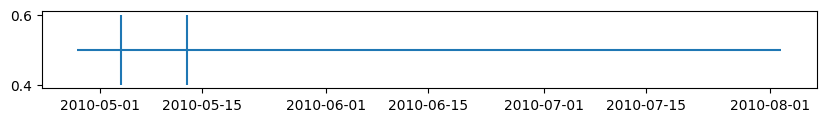

In [11]:
fig = plt.figure(figsize=(10, 1))
ax = plt.gca()

_ = plot_poisson_events(submissions_2435_team502, 0.5, 0.2, (contest_time_start, contest_time_end), ax)

### 3. Estimate the Arrival Rate (Intensity) of Submissions over Time

In [12]:
submissions_2435.dtypes

TeamId                     int64
SubmissionDate    datetime64[ns]
PublicScore              float64
PrivateScore             float64
CompetitionId              int64
EnabledDate       datetime64[ns]
DeadlineDate      datetime64[ns]
dtype: object